In [1]:
import phoebe
import numpy as np
from spice.models.phoebe_model import PhoebeModel

PHOEBE: passband "Bolometric:900-40000" has a newer version available.  Run phoebe.list_passband_online_history("Bolometric:900-40000") to get a list of available changes and phoebe.update_passband("Bolometric:900-40000") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.


In [2]:
import matplotlib
%matplotlib inline

In [3]:
import astropy.units as u
u.solRad.to(u.cm)

69570000000.0

In [4]:
from phoebe.parameters.dataset import _mesh_columns

In [70]:
b = phoebe.default_star()
b.set_quantity('incl', 90.)
times = np.linspace(0, 24*3600, 100)
COLUMNS = _mesh_columns
b.add_dataset('mesh', times=times, columns=COLUMNS, dataset='mesh01')
b.run_compute(irrad_method='none')


100%|██████████| 100/100 [00:00<00:00, 179.05it/s]


<ParameterSet: 3102 parameters | qualifiers: nws, xyz_elements, xyz_normals, nvs, vxs, rs, us, visibilities, mus, vs, vws, nys, uvw_normals, nzs, xs, vvs, vzs, areas, visible_centroids, vys, ws, comments, volume, times, vus, nxs, zs, uvw_elements, ys, loggs, nus, teffs, rprojs>

In [71]:
from spice.models.phoebe_utils import PhoebeConfig

In [72]:
p = PhoebeConfig(b, 'mesh01')

In [73]:
proj_vels = np.sqrt(
    np.power(b.get_parameter(qualifier='vus', kind='mesh', time=0.).value, 2)+
    np.power(b.get_parameter(qualifier='vvs', kind='mesh', time=0.).value, 2)+
    np.power(b.get_parameter(qualifier='vws', kind='mesh', time=0.).value, 2)
)
vis = b.get_parameter(qualifier='visibilities', kind='mesh', time=0.).value>=1.

In [74]:
vis

array([False, False, False, ...,  True,  True,  True])

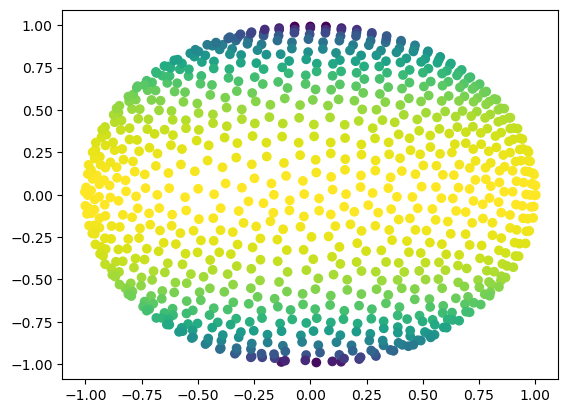

In [75]:
import matplotlib.pyplot as plt
plt.scatter(b.get_parameter(qualifier='us', kind='mesh', time=0.).value[vis],
            b.get_parameter(qualifier='vs', kind='mesh', time=0.).value[vis],
            c=proj_vels[vis], cmap='viridis')

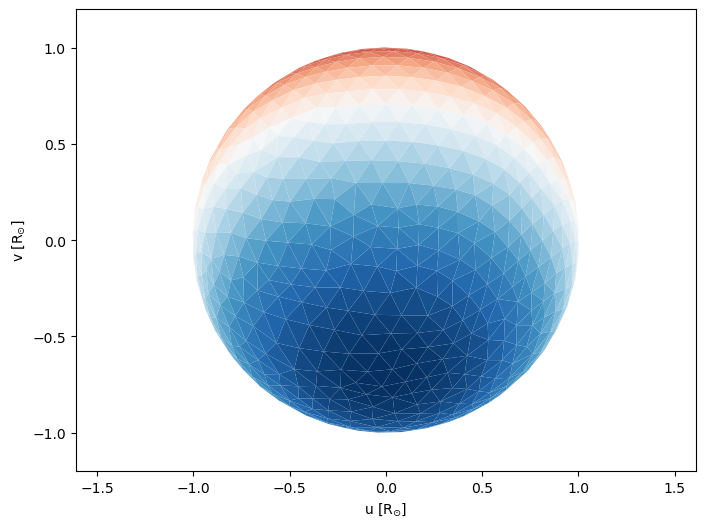

In [49]:

afig, mplfig = b.plot(kind='mesh', time=times[0], x='us', y='vs', fc='vus', ec='none', show=True, animate=False)

In [17]:
b.get_quantity('period')

<Quantity 1. d>

In [38]:
b.get_parameter(qualifier='vys', kind='mesh', time=0.).description

'Y velocity of center of triangles'

In [15]:
p.get_parameter(0., 'vs')

array([ 0.73007569,  0.75846807,  0.73007569, ..., -0.79264312,
       -0.84443447, -0.86740771])

In [9]:
b.get_parameter(qualifier='us', kind='mesh', time=0.).description

'U coordinate of center of triangles in the plane-of-sky'

In [10]:
b.get_parameter(qualifier='us', kind='mesh', time=0.)

<Parameter: us=[ 6.95468502e-02 -1.39218355e-17 -6.95468502e-02 ...
 -2.13770970e-01 -2.16994261e-01 -1.61341854e-01] solRad | keys: description, value, default_unit, visible_if, required_shape, copy_for, readonly, advanced, latexfmt>

In [11]:
p.get_parameter(0., 'rprojs')

array([0.73330991, 0.75808338, 0.73330991, ..., 0.81930459, 0.86988161,
       0.88092365])

In [12]:
p.get_loggs(0.)

array([4.44180955, 4.44180955, 4.44180955, ..., 4.44107348, 4.44059425,
       4.44064471])

In [13]:
pm = PhoebeModel.construct(p, 0.)

In [ ]:
import matplotlib.pyplot as plt

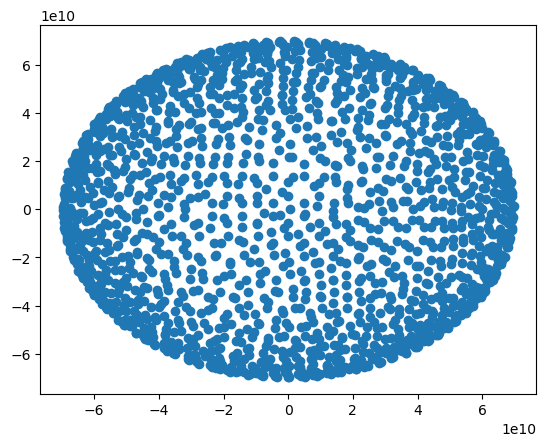

In [ ]:
plt.figure()
plt.scatter(pm.centers[:, 0], pm.centers[:, 1])

In [ ]:
pm.radius

1.0